In [1]:
# Standard scientific Python imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Import datasets, classifiers and performance metrics
from sklearn import datasets, metrics, svm
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch

In [2]:
if torch.cpu.is_available():
    torch.cpu.set_device("cpu")

In [3]:
torch.cpu.current_device()

'cpu'

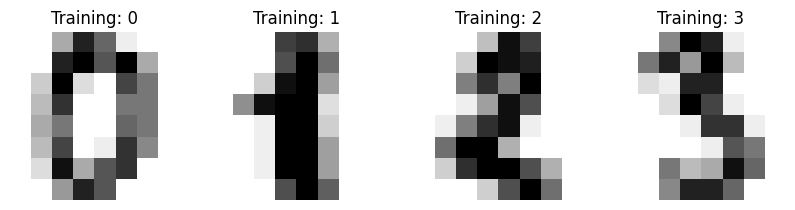

In [4]:
digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [5]:
data=pd.DataFrame(data=digits.data,columns=digits.feature_names)
target=pd.DataFrame(data=digits.target, columns=["target"])

In [6]:
data

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,0.0,0.0,4.0,10.0,13.0,6.0,0.0,0.0,0.0,1.0,...,4.0,0.0,0.0,0.0,2.0,14.0,15.0,9.0,0.0,0.0
1793,0.0,0.0,6.0,16.0,13.0,11.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,6.0,16.0,14.0,6.0,0.0,0.0
1794,0.0,0.0,1.0,11.0,15.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,9.0,13.0,6.0,0.0,0.0
1795,0.0,0.0,2.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,5.0,12.0,16.0,12.0,0.0,0.0


In [7]:
target

,target
0,0
1,1
2,2
3,3
4,4
...,...
1792,9
1793,0
1794,8
1795,9


In [8]:
# 3. Функции активации и их производные
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(a):
    return a * (1 - a)
def softmax(out) -> np.array:
    max_out = np.max(out)
    exps = np.exp(out - max_out)
    sum_exps = np.sum(exps)
    return exps / sum_exps


In [9]:
def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    limit1 = np.sqrt(6 / (input_size + hidden_size))
    w1 = np.random.uniform(-limit1, limit1, (hidden_size, input_size))
    
    limit2 = np.sqrt(6 / (hidden_size + hidden_size))
    w2 = np.random.uniform(-limit2, limit2, (hidden_size, hidden_size))
    
    limit3 = np.sqrt(6 / (hidden_size + output_size))
    w3 = np.random.uniform(-limit3, limit3, (output_size, hidden_size))
    
    print("shape w1: ", w1.shape, "\n", "shape w2: ", w2.shape, "\n", "shape w3: ", w3.shape)
    return w1, w2, w3

def forward_pass(X,w1,w2,w3):
    l1 = w1 @ X
    z1 = sigmoid(l1) 
    l2 = w2 @ z1
    z2 = sigmoid(l2)
    l3 = w3 @ z2
    out= softmax(l3)

    cache = (z1,z2,out) #кеш 
    return cache


def predict(X,w1,w2,w3):
    l1 = w1 @ X
    z1 = sigmoid(l1) 
    l2 = w2 @ z1
    z2 = sigmoid(l2)
    l3 = w3 @ z2
    out= softmax(l3)
    return out

def PREDICT(X,w1,w2,w3):
    p=[]
    x=X.values.tolist()
    for i in range(X.shape[0]):
        p.append(list(predict(x[i],w1,w2,w3)).index(max(predict(x[i],w1,w2,w3))))
    return p

def one_hot(label, num_classes=10):
    vec = np.zeros(num_classes)
    vec[label] = 1
    return vec

def compute_loss(prediction, target):
    # Кросс-энтропийный лосс
    return -np.log(prediction[target] + 1e-8)

def backward_pass(data, w1, w2, w3, cache, target, lr):
    z1, z2, out = cache
    z1 = np.expand_dims(z1, axis=1)

    target_one_hot = one_hot(target)
    delta3 = out - target_one_hot  # Градиент на выходном слое

    delta3 = np.expand_dims(delta3, axis=1)

    data = np.expand_dims(data, axis=1)
    z2 = np.expand_dims(z2, axis=1)

    # Обновление весов w3
    w3 -= lr * (delta3 @ z2.T)

    # Градиент для w2
    delta2 = (w3.T @ delta3) * sigmoid_derivative(z2)
    w2 -= lr * (delta2 @ z1.T)

    # Градиент для w1
    delta1 = (w2.T @ delta2) * sigmoid_derivative(z1)
    w1 -= lr * (delta1 @ data.T)

    return w1, w2, w3

def validate(y_true,y_pred,metrica="accuracy"):
    from sklearn.metrics import accuracy_score
    return accuracy_score(y_pred,y_true)


In [10]:
def train(x_train,y_train,lr,epoh):
    
    w1,w2,w3 = initialize_parameters(x_train.shape[1],128,10)

    for i in tqdm(range(epoh)):
        for _ in range(x_train.shape[0]):
            
            indx=np.random.randint(0,x_train.shape[0])

            cache= forward_pass(x_train.values[indx],w1,w2,w3)

            pred=predict(x_train.values[indx],w1,w2,w3)

            loss=compute_loss(pred,y_train.values[indx])

            w1 ,w2,w3 = backward_pass(x_train.values[indx],w1,w2,w3,cache,y_train.values[indx],0.01)

    return w1,w2,w3

In [11]:
x_train,x_test,y_train,y_test= train_test_split(data,target,test_size=.2,random_state=42)


In [12]:
w1,w2,w3 = initialize_parameters(x_train.shape[1],128,10)

shape w1:  (128, 64) 
 shape w2:  (128, 128) 
 shape w3:  (10, 128)


In [13]:
indx=np.random.randint(0,x_train.shape[0])
indx

527

In [14]:
cache= forward_pass(x_train.values[indx],w1,w2,w3)

In [15]:
pred=predict(x_train.values[indx],w1,w2,w3)
pred

array([0.07435725, 0.09565178, 0.05661373, 0.14651931, 0.15169498,
       0.0706028 , 0.13667989, 0.05776807, 0.04778159, 0.16233061])

In [16]:
loss=compute_loss(pred,y_train.values[indx])

In [17]:
w1 ,w2,w3 = backward_pass(x_train.values[indx],w1,w2,w3,cache,y_train.values[indx],0.01)

In [18]:
w1,w2,w3=train(x_train,y_train,0.01,20)

shape w1:  (128, 64) 
 shape w2:  (128, 128) 
 shape w3:  (10, 128)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:02<00:00,  6.90it/s]


In [19]:
validate(y_test,PREDICT(x_test,w1,w2,w3))

0.975